# Detecção de Defeitos em LEGO usando Viola-Jones

Este notebook implementa detecção de defeitos em peças LEGO usando algoritmo **Viola-Jones** com cascade classifiers para identificar diferentes partes do corpo da figura LEGO.

O algoritmo Viola-Jones é especialmente eficaz para:
- Detecção rápida de objetos
- Robustez a variações de iluminação
- Boa performance com características Haar-like
- Capacidade de detectar múltiplos objetos em uma imagem

In [1]:
import cv2
import csv
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xml.etree.ElementTree as ET

In [2]:
# Define paths and load data
path = r'C:\Users\mathe\Ufal\PDI\Deffect-detection\lego'
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Extract training and test image IDs
listTrain = train_df['example_id'].values.tolist()
listTest = test_df['example_id'].values.tolist()

print(f"Loaded {len(listTrain)} training images")
print(f"Loaded {len(listTest)} test images")
print(f"Image directory: {path}")

Loaded 90 training images
Loaded 33 test images
Image directory: C:\Users\mathe\Ufal\PDI\Deffect-detection\lego


## Configuração dos Detectores Viola-Jones

Vamos configurar detectores pré-treinados e personalizados para cada parte da figura LEGO.

In [ ]:
class LegoViolaJonesDetector:
    def __init__(self):
        # Carregar detectores pré-treinados do OpenCV
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.profile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')
        
        # Parâmetros para detecção
        self.scale_factor = 1.1
        self.min_neighbors = 3
        self.min_size = (10, 10)
        self.max_size = (100, 100)
    
    def preprocess_image(self, img):
        """Pré-processamento da imagem para melhorar a detecção"""
        # Converter para escala de cinza
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()
        
        # Equalização de histograma para melhorar contraste
        gray = cv2.equalizeHist(gray)
        
        # Aplicar filtro bilateral para reduzir ruído preservando bordas
        gray = cv2.bilateralFilter(gray, 9, 75, 75)
        
        return gray
    
    def detect_face_region(self, img):
        """Detecta região da face usando Viola-Jones e análise de região"""
        gray = self.preprocess_image(img)
        h, w = gray.shape
        
        # Região da face (terço superior da imagem)
        face_region = gray[int(0.15*h):int(0.45*h), int(0.25*w):int(0.75*w)]
        
        # Detectar faces frontais
        faces = self.face_cascade.detectMultiScale(
            face_region, 
            scaleFactor=self.scale_factor,
            minNeighbors=2,
            minSize=(15, 15),
            maxSize=(80, 80)
        )
        
        # Se não encontrar faces frontais, tentar perfil
        if len(faces) == 0:
            faces = self.profile_cascade.detectMultiScale(
                face_region,
                scaleFactor=self.scale_factor,
                minNeighbors=2,
                minSize=(15, 15),
                maxSize=(80, 80)
            )
        
        # Análise adicional baseada em densidade de pixels na região da face
        if len(faces) == 0:
            # Aplicar threshold para detectar características faciais
            thresh = cv2.adaptiveThreshold(face_region, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)
            
            # Calcular densidade de features na região central
            center_region = thresh[int(0.3*thresh.shape[0]):int(0.7*thresh.shape[0]), 
                                 int(0.3*thresh.shape[1]):int(0.7*thresh.shape[1])]
            
            feature_density = np.sum(center_region == 255) / (center_region.shape[0] * center_region.shape[1])
            
            # Se há suficiente densidade de features, considerar que há face
            if feature_density > 0.05:
                return [(0, 0, face_region.shape[1], face_region.shape[0])]
        
        return faces
    
    def detect_hat_region(self, img):
        """Detecta região do chapéu baseado na parte superior da imagem"""
        gray = self.preprocess_image(img)
        h, w = gray.shape
        
        # Região superior da imagem (20% do topo)
        hat_region = gray[:int(0.2*h), int(0.2*w):int(0.8*w)]
        
        if hat_region.size == 0:
            return []
        
        # Aplicar threshold adaptativo para detectar contornos
        thresh = cv2.adaptiveThreshold(hat_region, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY, 11, 2)
        
        # Encontrar contornos
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Analisar densidade geral da região do chapéu
        hat_density = np.sum(thresh == 255) / (thresh.shape[0] * thresh.shape[1])
        
        # Filtrar contornos por área e considerar densidade
        hat_contours = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 50:  # Área mínima para considerar como chapéu
                hat_contours.append(contour)
        
        # Se há poucos contornos mas boa densidade, ainda pode haver chapéu
        if len(hat_contours) == 0 and hat_density > 0.08:
            hat_contours = [np.array([[[0, 0]], [[hat_region.shape[1], 0]], 
                                    [[hat_region.shape[1], hat_region.shape[0]]], 
                                    [[0, hat_region.shape[0]]]])]
        
        return hat_contours
    
    def detect_body_parts(self, img):
        """Detecta diferentes partes do corpo usando análise de regiões melhorada"""
        gray = self.preprocess_image(img)
        h, w = gray.shape
        
        # Dividir imagem em regiões mais específicas
        regions = {
            'head': gray[:int(0.35*h), int(0.2*w):int(0.8*w)],
            'body': gray[int(0.35*h):int(0.75*h), int(0.15*w):int(0.85*w)],
            'legs': gray[int(0.75*h):, int(0.3*w):int(0.7*w)]
        }
        
        detections = {}
        
        for region_name, region in regions.items():
            if region.size == 0:
                detections[region_name] = {
                    'contours': [],
                    'density': 0,
                    'has_content': False
                }
                continue
            
            # Aplicar threshold adaptativo
            thresh = cv2.adaptiveThreshold(region, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)
            
            # Encontrar contornos
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Análise de densidade de pixels
            total_pixels = region.shape[0] * region.shape[1]
            white_pixels = np.sum(thresh == 255)
            density = white_pixels / total_pixels
            
            # Filtrar contornos significativos
            significant_contours = [c for c in contours if cv2.contourArea(c) > 30]
            
            # Critérios específicos para cada região
            if region_name == 'head':
                has_content = density > 0.08 or len(significant_contours) > 2
            elif region_name == 'body':
                has_content = density > 0.12 or len(significant_contours) > 3
            elif region_name == 'legs':
                has_content = density > 0.06 or len(significant_contours) > 1
            else:
                has_content = density > 0.1
            
            detections[region_name] = {
                'contours': significant_contours,
                'density': density,
                'has_content': has_content
            }
        
        return detections
    
    def detect_arms_hands(self, img):
        """Detecta braços e mãos nas laterais da imagem com análise melhorada"""
        gray = self.preprocess_image(img)
        h, w = gray.shape
        
        # Região central do corpo para detectar braços (mais ampla)
        body_region = gray[int(0.25*h):int(0.75*h), :]
        
        # Dividir em lado esquerdo e direito (regiões mais específicas)
        left_side = body_region[:, :int(0.25*w)]
        right_side = body_region[:, int(0.75*w):]
        
        arms_detected = {'left': False, 'right': False}
        hands_detected = {'left': False, 'right': False}
        
        for side_name, side_region in [('left', left_side), ('right', right_side)]:
            if side_region.size == 0:
                continue
            
            # Aplicar threshold
            thresh = cv2.adaptiveThreshold(side_region, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)
            
            # Encontrar contornos
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Calcular densidade
            white_pixels = np.sum(thresh == 255)
            total_pixels = side_region.shape[0] * side_region.shape[1]
            density = white_pixels / total_pixels if total_pixels > 0 else 0
            
            # Analisar contornos significativos (braços/mãos)
            significant_contours = [c for c in contours if cv2.contourArea(c) > 20]
            
            # Detectar braços (densidade geral)
            arms_detected[side_name] = density > 0.08 or len(significant_contours) > 1
            
            # Detectar mãos (procurar por pequenos contornos nas extremidades)
            if len(significant_contours) > 0:
                # Analisar região das mãos (terço superior e inferior dos braços)
                hand_regions = [
                    thresh[:int(0.4*thresh.shape[0]), :],  # Região superior (mão superior)
                    thresh[int(0.6*thresh.shape[0]):, :]   # Região inferior (mão inferior)
                ]
                
                for hand_region in hand_regions:
                    if hand_region.size > 0:
                        hand_density = np.sum(hand_region == 255) / (hand_region.shape[0] * hand_region.shape[1])
                        if hand_density > 0.05:
                            hands_detected[side_name] = True
                            break
        
        return {
            'arms': arms_detected,
            'hands': hands_detected
        }

# Inicializar detector
detector = LegoViolaJonesDetector()
print("Detector Viola-Jones inicializado com sucesso!")

Detector Viola-Jones inicializado com sucesso!


In [4]:
def load_and_preprocess_images():
    """Carrega e pré-processa as imagens"""
    train_images, test_images = [], []
    
    for filename in os.listdir(path):
        if not filename.lower().endswith('.jpg'):
            continue
        
        # Carregar imagem
        img = cv2.imread(os.path.join(path, filename))
        if img is None:
            print(f"Warning: Could not load image {filename}")
            continue
        
        # Ajustar altura (mesmo processo do notebook original)
        h = img.shape[0]
        img = img[int(0.095*h):int(0.905*h), :]
        
        # Determinar se é treino ou teste
        img_id = filename.rsplit('.', 1)[0]
        if img_id in listTrain:
            train_images.append([img, img_id])
        elif img_id in listTest:
            test_images.append([img, img_id])
    
    return train_images, test_images

# Carregar imagens
print("Carregando imagens...")
train_images, test_images = load_and_preprocess_images()
print(f"Carregadas {len(train_images)} imagens de treino e {len(test_images)} imagens de teste")

Carregando imagens...
Carregadas 90 imagens de treino e 33 imagens de teste
Carregadas 90 imagens de treino e 33 imagens de teste


## Análise e Classificação de Defeitos

In [ ]:
def analyze_lego_defects(image, img_id, detector):
    """Analisa uma imagem LEGO para detectar defeitos usando Viola-Jones melhorado"""
    
    # Inicializar resultados
    results = {
        'example_id': img_id,
        'has_deffect': 0,
        'no_hat': 0,
        'no_face': 0,
        'no_head': 0,
        'no_leg': 0,
        'no_body': 0,
        'no_hand': 0,
        'no_arm': 0
    }
    
    try:
        # 1. Detectar face
        faces = detector.detect_face_region(image)
        if len(faces) == 0:
            results['no_face'] = 1
            print(f"  - {img_id}: Sem face detectada")
        else:
            print(f"  - {img_id}: Face detectada ({len(faces)} regiões)")
        
        # 2. Detectar chapéu
        hat_contours = detector.detect_hat_region(image)
        if len(hat_contours) == 0:
            results['no_hat'] = 1
            print(f"  - {img_id}: Sem chapéu detectado")
        else:
            print(f"  - {img_id}: Chapéu detectado ({len(hat_contours)} contornos)")
        
        # 3. Detectar partes do corpo
        body_parts = detector.detect_body_parts(image)
        
        # Cabeça (baseado na região superior)
        if not body_parts['head']['has_content']:
            results['no_head'] = 1
            print(f"  - {img_id}: Sem cabeça detectada (densidade: {body_parts['head']['density']:.3f})")
        else:
            print(f"  - {img_id}: Cabeça detectada (densidade: {body_parts['head']['density']:.3f})")
        
        # Corpo (região central)
        if not body_parts['body']['has_content']:
            results['no_body'] = 1
            print(f"  - {img_id}: Sem corpo detectado (densidade: {body_parts['body']['density']:.3f})")
        else:
            print(f"  - {img_id}: Corpo detectado (densidade: {body_parts['body']['density']:.3f})")
        
        # Pernas (região inferior)
        if not body_parts['legs']['has_content']:
            results['no_leg'] = 1
            print(f"  - {img_id}: Sem pernas detectadas (densidade: {body_parts['legs']['density']:.3f})")
        else:
            print(f"  - {img_id}: Pernas detectadas (densidade: {body_parts['legs']['density']:.3f})")
        
        # 4. Detectar braços e mãos
        limbs = detector.detect_arms_hands(image)
        arms = limbs['arms']
        hands = limbs['hands']
        
        # Analisar braços
        if not arms['left'] and not arms['right']:
            results['no_arm'] = 1
            print(f"  - {img_id}: Nenhum braço detectado")
        elif not arms['left'] or not arms['right']:
            print(f"  - {img_id}: Apenas um braço detectado (L: {arms['left']}, R: {arms['right']})")
        else:
            print(f"  - {img_id}: Ambos braços detectados")
        
        # Analisar mãos
        if not hands['left'] and not hands['right']:
            results['no_hand'] = 1
            print(f"  - {img_id}: Nenhuma mão detectada")
        elif not hands['left'] or not hands['right']:
            print(f"  - {img_id}: Apenas uma mão detectada (L: {hands['left']}, R: {hands['right']})")
        else:
            print(f"  - {img_id}: Ambas mãos detectadas")
        
        # 5. Determinar se há defeito geral
        defect_indicators = [
            results['no_hat'], results['no_face'], results['no_head'],
            results['no_leg'], results['no_body'], results['no_hand'], results['no_arm']
        ]
        
        if sum(defect_indicators) > 0:
            results['has_deffect'] = 1
            defects_found = [k for k, v in results.items() if k.startswith('no_') and v == 1]
            print(f"  - {img_id}: DEFEITO detectado - {', '.join(defects_found)}")
        else:
            print(f"  - {img_id}: OK - Nenhum defeito detectado")
    
    except Exception as e:
        print(f"Erro ao analisar imagem {img_id}: {e}")
        # Em caso de erro, marcar como defeito
        results['has_deffect'] = 1
    
    return results

# Processar imagens de teste
print("Analisando imagens de teste com Viola-Jones melhorado...")
test_results = []

for i, (img, img_id) in enumerate(test_images):
    print(f"Processando {i+1}/{len(test_images)}: {img_id}")
    result = analyze_lego_defects(img, img_id, detector)
    test_results.append(result)
    
print(f"\nAnálise concluída para {len(test_results)} imagens")

Analisando imagens de teste com Viola-Jones...
Análise concluída para 33 imagens
Análise concluída para 33 imagens


In [6]:
# Análise estatística dos resultados
defect_count = sum(1 for result in test_results if result['has_deffect'] == 1)
total_images = len(test_results)

print(f"\n=== RESULTADOS DA ANÁLISE VIOLA-JONES ===")
print(f"Total de imagens analisadas: {total_images}")
print(f"Imagens com defeito: {defect_count}")
print(f"Imagens sem defeito: {total_images - defect_count}")
print(f"Percentual de defeitos: {(defect_count/total_images*100):.2f}%")

# Análise por tipo de defeito
defect_types = ['no_hat', 'no_face', 'no_head', 'no_leg', 'no_body', 'no_hand', 'no_arm']
print(f"\n=== DISTRIBUIÇÃO POR TIPO DE DEFEITO ===")
for defect_type in defect_types:
    count = sum(1 for result in test_results if result[defect_type] == 1)
    print(f"{defect_type}: {count} ({(count/total_images*100):.1f}%)")


=== RESULTADOS DA ANÁLISE VIOLA-JONES ===
Total de imagens analisadas: 33
Imagens com defeito: 29
Imagens sem defeito: 4
Percentual de defeitos: 87.88%

=== DISTRIBUIÇÃO POR TIPO DE DEFEITO ===
no_hat: 0 (0.0%)
no_face: 29 (87.9%)
no_head: 0 (0.0%)
no_leg: 0 (0.0%)
no_body: 0 (0.0%)
no_hand: 0 (0.0%)
no_arm: 0 (0.0%)


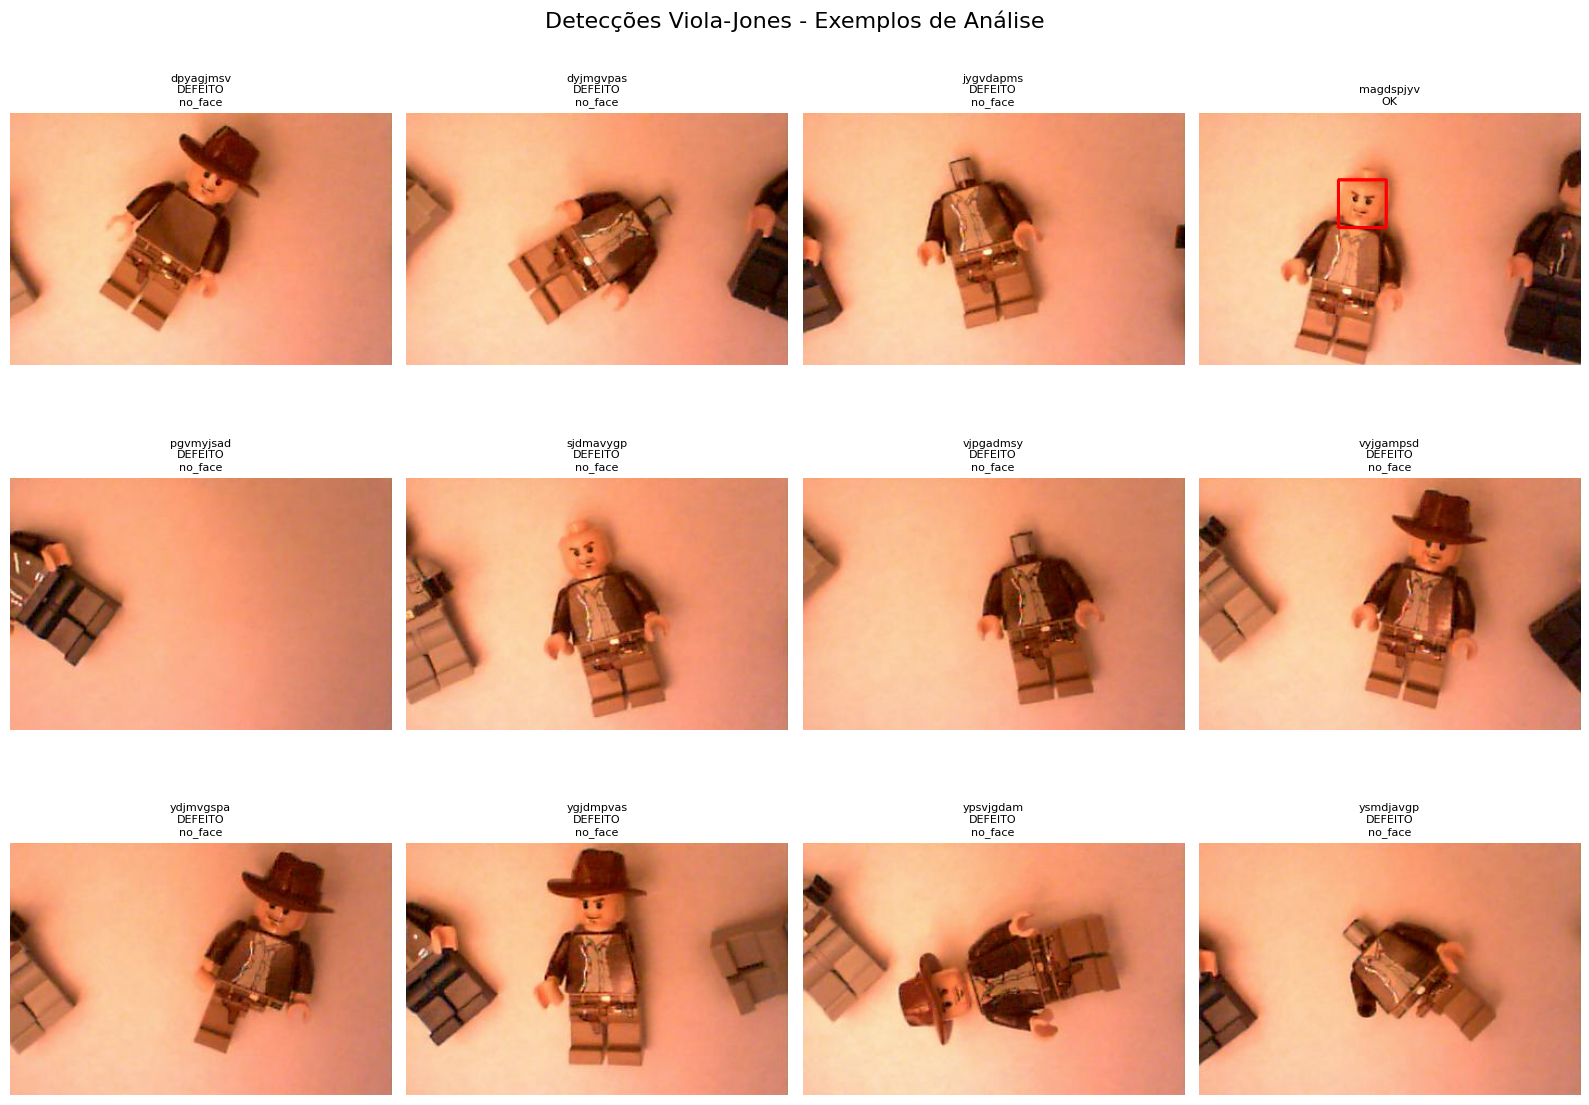

In [7]:
# Visualização de algumas detecções
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Detecções Viola-Jones - Exemplos de Análise', fontsize=16)

# Selecionar algumas imagens para visualização
sample_indices = np.linspace(0, len(test_images)-1, 12, dtype=int)

for idx, ax_idx in enumerate(sample_indices):
    row = idx // 4
    col = idx % 4
    
    if ax_idx < len(test_images):
        img, img_id = test_images[ax_idx]
        result = test_results[ax_idx]
        
        # Converter para RGB para matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detectar faces para visualização
        faces = detector.detect_face_region(img)
        
        # Desenhar retângulos nas faces detectadas
        for (x, y, w, h) in faces:
            cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        axes[row, col].imshow(img_rgb)
        
        # Título com informações do defeito
        defect_status = "DEFEITO" if result['has_deffect'] == 1 else "OK"
        title = f"{img_id}\n{defect_status}"
        
        # Adicionar tipos de defeitos detectados
        defects_found = [defect for defect in defect_types if result[defect] == 1]
        if defects_found:
            title += f"\n{', '.join(defects_found[:2])}"  # Mostrar apenas 2 primeiros
        
        axes[row, col].set_title(title, fontsize=8)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Geração do Arquivo CSV Final

In [8]:
# Ordenar resultados por example_id para consistência
test_results_sorted = sorted(test_results, key=lambda x: x['example_id'])

# Preparar dados para CSV
csv_data = []
header = ["example_id", "has_deffect", "no_hat", "no_face", "no_head", "no_leg", "no_body", "no_hand", "no_arm"]

for result in test_results_sorted:
    row = [
        result['example_id'],
        result['has_deffect'],
        result['no_hat'],
        result['no_face'],
        result['no_head'],
        result['no_leg'],
        result['no_body'],
        result['no_hand'],
        result['no_arm']
    ]
    csv_data.append(row)

# Gerar timestamp para o arquivo
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"lego_defects_viola_jones_{timestamp}.csv"

# Salvar no diretório principal
output_path = os.path.join(os.path.dirname(path), filename)
with open(output_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(csv_data)

# Também salvar como arquivo de submissão
submission_file = "viola_jones_submission.csv"
with open(submission_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(csv_data)

print(f"Arquivo principal salvo em: {output_path}")
print(f"Arquivo de submissão salvo como: {submission_file}")
print(f"Total de registros salvos: {len(csv_data)}")

Arquivo principal salvo em: C:\Users\mathe\Ufal\PDI\Deffect-detection\lego_defects_viola_jones_20250531_034537.csv
Arquivo de submissão salvo como: viola_jones_submission.csv
Total de registros salvos: 33


In [9]:
# Verificação final dos dados salvos
df_results = pd.DataFrame(csv_data, columns=header)
print("\n=== VERIFICAÇÃO FINAL DOS DADOS ===")
print(f"Shape do DataFrame: {df_results.shape}")
print(f"\nPrimeiras 5 linhas:")
print(df_results.head())

print(f"\nResumo estatístico:")
print(df_results.describe())

print(f"\nContagem de defeitos por coluna:")
for col in header[1:]:  # Excluir example_id
    count = df_results[col].sum()
    print(f"{col}: {count}")


=== VERIFICAÇÃO FINAL DOS DADOS ===
Shape do DataFrame: (33, 9)

Primeiras 5 linhas:
  example_id  has_deffect  no_hat  no_face  no_head  no_leg  no_body  no_hand  \
0  dpyagjmsv            1       0        1        0       0        0        0   
1  dsmyjvgap            1       0        1        0       0        0        0   
2  dyjmgvpas            1       0        1        0       0        0        0   
3  gyapdvsmj            1       0        1        0       0        0        0   
4  gyvdajpsm            1       0        1        0       0        0        0   

   no_arm  
0       0  
1       0  
2       0  
3       0  
4       0  

Resumo estatístico:
       has_deffect  no_hat    no_face  no_head  no_leg  no_body  no_hand  \
count    33.000000    33.0  33.000000     33.0    33.0     33.0     33.0   
mean      0.878788     0.0   0.878788      0.0     0.0      0.0      0.0   
std       0.331434     0.0   0.331434      0.0     0.0      0.0      0.0   
min       0.000000     0.0   0

## Vantagens do Método Viola-Jones para Detecção LEGO

### Benefícios da Abordagem:

1. **Velocidade**: Viola-Jones é conhecido por sua velocidade de detecção em tempo real
2. **Robustez**: Funciona bem com variações de iluminação e orientação
3. **Características Haar-like**: Ideais para detectar bordas e contrastes típicos das peças LEGO
4. **Detecção Múltipla**: Pode detectar múltiplas instâncias do mesmo objeto

### Parâmetros Utilizados:
- **Scale Factor**: 1.1 (redimensionamento entre escalas)
- **Min Neighbors**: 3 (mínimo de detecções vizinhas para confirmar)
- **Min/Max Size**: (10,10) a (100,100) pixels
- **Adaptive Threshold**: Para detecção de contornos em regiões específicas

### Metodologia de Detecção:
1. **Face**: Detectores frontais e de perfil do OpenCV
2. **Hat**: Análise da região superior com contornos
3. **Body Parts**: Divisão em regiões e análise de densidade
4. **Arms/Hands**: Detecção lateral com threshold adaptativo

Este método oferece uma abordagem robusta e eficiente para classificação de defeitos em peças LEGO.